In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from itertools import combinations
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

### Load data

In [2]:
train_cleaned = pd.read_csv('https://raw.githubusercontent.com/MohamedMostafa259/Customer-Churn-Prediction-and-Analysis/main/Milestone1_DataCollection_EDA_DataCleaning/data/train_cleaned_imputed.csv')
train_cleaned.head()

,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,18,F,Village,Platinum Membership,2017-08-17,No,Gift Vouchers/Coupons,Desktop,Wi-Fi,16:08:02,...,300.63,53005.25,17.0,781.750000,Yes,Yes,No,Not Applicable,Products always in Stock,2.0
1,32,F,City,Premium Membership,2017-08-28,No,Gift Vouchers/Coupons,Desktop,Mobile_Data,12:38:13,...,306.34,12838.38,10.0,788.732956,Yes,No,Yes,Solved,Quality Customer Care,1.0
2,44,F,Town,No Membership,2016-11-11,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,22:53:21,...,516.16,21027.00,22.0,500.690000,No,Yes,Yes,Solved in Follow-up,Poor Website,5.0
3,37,M,City,No Membership,2016-10-29,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,15:57:50,...,53.27,25239.56,6.0,567.660000,No,Yes,Yes,Unsolved,Poor Website,5.0
4,31,F,City,No Membership,2017-09-12,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,15:46:44,...,113.13,24483.66,16.0,663.060000,No,Yes,Yes,Solved,Poor Website,5.0


#### Create a copy for feature engineering

In [3]:
train_cleaned_copy = train_cleaned.copy()

### Explore columns

In [4]:
train_cleaned_copy.columns

Index(['age', 'gender', 'region_category', 'membership_category',
       'joining_date', 'joined_through_referral', 'preferred_offer_types',
       'medium_of_operation', 'internet_option', 'last_visit_time',
       'days_since_last_login', 'avg_time_spent', 'avg_transaction_value',
       'avg_frequency_login_days', 'points_in_wallet', 'used_special_discount',
       'offer_application_preference', 'past_complaint', 'complaint_status',
       'feedback', 'churn_risk_score'],
      dtype='object')

In [5]:
train_cleaned_copy.select_dtypes('number').columns

Index(['age', 'days_since_last_login', 'avg_time_spent',
       'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet',
       'churn_risk_score'],
      dtype='object')

### Extracting features

In [6]:
train_cleaned_copy['points_per_transaction'] = train_cleaned_copy['points_in_wallet'] / train_cleaned_copy['avg_transaction_value']
train_cleaned_copy['transaction_value_per_time_unit'] = train_cleaned_copy['avg_transaction_value'] / train_cleaned_copy['avg_time_spent']

In [7]:
def time_of_day(hour):
	if 5 <= hour < 12:
		return 'Morning'
	elif 12 <= hour < 17:
		return 'Afternoon'
	elif 17 <= hour < 21:
		return 'Evening'
	else:
		return 'Night'

In [8]:
def ampm_mapping(hour):
	if 0 <= hour < 12:
		return 'AM'
	else:
		return 'PM'

In [9]:
train_cleaned_copy['last_visit_hour'] = pd.to_datetime(train_cleaned_copy['last_visit_time']).dt.hour
train_cleaned_copy['last_visit_time_of_day'] = train_cleaned_copy['last_visit_hour'].apply(time_of_day)
train_cleaned_copy['last_visit_AMPM'] = train_cleaned_copy['last_visit_hour'].apply(ampm_mapping)

In [10]:
train_cleaned_copy['joining_date'] = pd.to_datetime(train_cleaned_copy['joining_date'])
train_cleaned_copy['joining_day_name'] = train_cleaned_copy['joining_date'].dt.day_name()

In [11]:
train_cleaned_copy['is_weekend'] = ((train_cleaned_copy['joining_day_name'] == 'Sunday') | 
									(train_cleaned_copy['joining_day_name'] == 'Saturday')).astype(int) 

### Save data (ready for advanced analysis)

In [12]:
train_cleaned_copy.isna().sum()

age                                0
gender                             0
region_category                    0
membership_category                0
joining_date                       0
joined_through_referral            0
preferred_offer_types              0
medium_of_operation                0
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                   0
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
points_per_transaction             0
transaction_value_per_time_unit    0
last_visit_hour                    0
last_visit_time_of_day             0
last_visit_AMPM                    0
joining_day_name                   0
i

In [13]:
train_cleaned_copy.to_csv('train_basicFeatureEng.csv', index=False)

In [14]:
train_cleaned_copy.select_dtypes(np.number).columns.tolist()

['age',
 'days_since_last_login',
 'avg_time_spent',
 'avg_transaction_value',
 'avg_frequency_login_days',
 'points_in_wallet',
 'churn_risk_score',
 'points_per_transaction',
 'transaction_value_per_time_unit',
 'last_visit_hour',
 'is_weekend']

In [15]:
scale_cols = ['age', 'days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 
			  'avg_frequency_login_days', 'points_in_wallet', 'points_per_transaction', 
              'transaction_value_per_time_unit', 'last_visit_hour']

## Encoding categorical variables

In [16]:
for col in train_cleaned_copy.select_dtypes(exclude='number').columns:
	if col in ['joining_date', 'last_visit_time']:
		continue
	print(f'{col} Column', '-'*50)
	print(train_cleaned_copy[col].unique())

gender Column --------------------------------------------------
['F' 'M' 'Unknown']
region_category Column --------------------------------------------------
['Village' 'City' 'Town']
membership_category Column --------------------------------------------------
['Platinum Membership' 'Premium Membership' 'No Membership'
 'Gold Membership' 'Silver Membership' 'Basic Membership']
joined_through_referral Column --------------------------------------------------
['No' 'Yes']
preferred_offer_types Column --------------------------------------------------
['Gift Vouchers/Coupons' 'Credit/Debit Card Offers' 'Without Offers']
medium_of_operation Column --------------------------------------------------
['Desktop' 'Smartphone' 'Both']
internet_option Column --------------------------------------------------
['Wi-Fi' 'Mobile_Data' 'Fiber_Optic']
used_special_discount Column --------------------------------------------------
['Yes' 'No']
offer_application_preference Column ----------------------

In [17]:
one_hot_cols = list(set(train_cleaned_copy.select_dtypes(exclude='number').columns.tolist()) - 
					{'joining_date', 'last_visit_time'} - {'membership_category', 'feedback'})
one_hot_cols

['last_visit_AMPM',
 'preferred_offer_types',
 'used_special_discount',
 'joined_through_referral',
 'gender',
 'joining_day_name',
 'past_complaint',
 'last_visit_time_of_day',
 'medium_of_operation',
 'internet_option',
 'region_category',
 'offer_application_preference',
 'complaint_status']

#### One-Hot Encoding (includes binary encoding)

In [18]:
train_cleaned_copy = pd.get_dummies(train_cleaned_copy, columns=one_hot_cols, drop_first=True, dtype=int)

#### Ordinal Encoding

In [19]:
# ordinal_cols = ['membership_category', 'feedback']
train_cleaned_copy['membership_category'] = pd.Categorical(train_cleaned_copy['membership_category'], 
														   categories=['No Membership', 'Basic Membership', 'Silver Membership', 
																	   'Gold Membership', 'Platinum Membership', 'Premium Membership'],
															ordered=True).codes

In [20]:
positive_feedback = ['Products always in Stock', 'Quality Customer Care', 'Reasonable Price', 'User Friendly Website']
negative_feedback = ['Poor Website' ,'Poor Customer Service', 'Poor Product Quality', 'Too many ads']
neutral_feedback = ['No reason specified']

def get_sentiment(feedback):
	if feedback in positive_feedback:
		return 1
	elif feedback in negative_feedback:
		return -1
	else:
		return 0 # neutral
	
train_cleaned_copy['feedback'] = train_cleaned_copy['feedback'].transform(get_sentiment)

#### General transformations numeric features

In [21]:
for num_col in train_cleaned_copy.select_dtypes(include=np.number).columns:
	train_cleaned_copy[f'{num_col}_sqrt'] = np.sqrt(train_cleaned_copy[num_col] + 1)
	train_cleaned_copy[f'{num_col}_square'] = np.square(train_cleaned_copy[num_col])
	train_cleaned_copy[f'{num_col}_log'] = np.log1p(train_cleaned_copy[num_col] + 0.01)  

The cell below is from the EDA.ipynb notebook in milestone 1

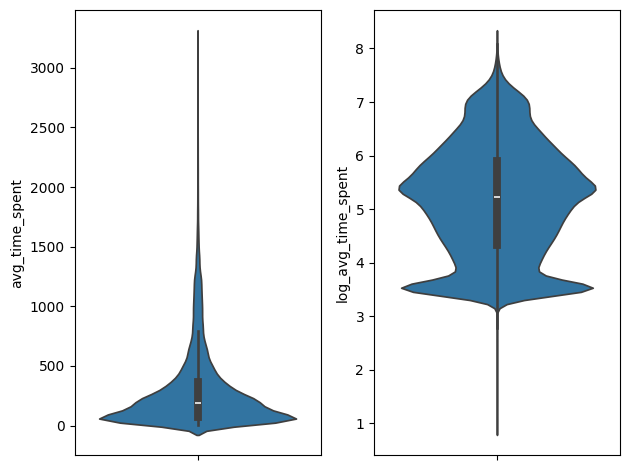

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# log1p(x) = log(x + 1): this avoids errors when x = 0
train_cleaned_copy['log_avg_time_spent'] = np.log1p(train_cleaned_copy['avg_time_spent'])

fig, axes = plt.subplots(1, 2)
sns.violinplot(train_cleaned_copy['avg_time_spent'], ax=axes[0])
sns.violinplot(train_cleaned_copy['log_avg_time_spent'], ax=axes[1])
plt.tight_layout()
plt.show()

In [24]:
train_cleaned_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35829 entries, 0 to 35828
Columns: 167 entries, age to log_avg_time_spent
dtypes: datetime64[ns](1), float16(1), float64(98), int32(60), int64(4), int8(2), object(1)
memory usage: 36.8+ MB


In [25]:
pd.set_option('display.max_rows', None)
train_cleaned_copy.corr(numeric_only=True)['churn_risk_score'].sort_values(ascending=False)

churn_risk_score                                      1.000000
churn_risk_score_sqrt                                 0.996109
churn_risk_score_log                                  0.983755
churn_risk_score_square                               0.979841
avg_frequency_login_days_log                          0.276452
avg_frequency_login_days_sqrt                         0.259556
avg_frequency_login_days                              0.238414
avg_frequency_login_days_square                       0.184142
joined_through_referral_Yes                           0.071403
joined_through_referral_Yes_square                    0.071403
joined_through_referral_Yes_sqrt                      0.071403
joined_through_referral_Yes_log                       0.071403
preferred_offer_types_Without Offers_sqrt             0.062734
preferred_offer_types_Without Offers_square           0.062734
preferred_offer_types_Without Offers                  0.062734
preferred_offer_types_Without Offers_log              0

In [26]:
train_cleaned_copy.isna().sum()[train_cleaned_copy.isna().sum() > 0]

Series([], dtype: int64)

features that we may need to transform are:

- `avg_time_spent`:

	avg_time_spent                                       -0.027045

	avg_time_spent_sqrt                                  -0.031828

	avg_time_spent_log                                   -0.032828

- `avg_transaction_value`:

	avg_transaction_value                                -0.362539

	avg_transaction_value_square                         -0.429874

In [27]:
scale_cols.append('avg_transaction_value_square')

In [28]:
pd.reset_option('display.max_rows')

## Build Feature Engineering pipeline

### FeatureEng custom transformer

In [29]:
# X is DataFrame of training features
# r_list is a list of desired combination sizes
# returns DataFrame with new combination features, excluding original categorical columns
def create_categorical_combinations(X, r_list, cat_cols):
	df_str = X[cat_cols].astype(str) # to allow concatenation
	for r in r_list:
		# generate all combinations of length r
		combinations_iter = combinations(cat_cols, r)
		for comb in combinations_iter:
			df_str['+'.join(comb)] = df_str[list(comb)].agg(''.join, axis=1)
	return df_str.drop(columns=cat_cols)

In [30]:
class FeatureEng(BaseEstimator, TransformerMixin):
	def __init__(self):
		self.membership_order = ['No Membership', 'Basic Membership', 'Silver Membership',
								 'Gold Membership', 'Platinum Membership', 'Premium Membership']
		self.positive_feedback = ['Products always in Stock', 'Quality Customer Care', 'Reasonable Price', 'User Friendly Website']
		self.negative_feedback = ['Poor Website', 'Poor Customer Service', 'Poor Product Quality', 'Too many ads']

	def time_of_day(self, hour):
		if 5 <= hour < 12:
			return 'Morning'
		elif 12 <= hour < 17:
			return 'Afternoon'
		elif 17 <= hour < 21:
			return 'Evening'
		else:
			return 'Night'
	
	def ampm_mapping(self, hour):
		return 'AM' if 0 <= hour < 12 else 'PM'

	def get_sentiment(self, feedback):
		if feedback in self.positive_feedback:
			return 1
		elif feedback in self.negative_feedback:
			return -1
		else:
			return 0

	def fit(self, X, y=None):
		return self

	def transform(self, X):
		X = X.copy()
		
		X['points_per_transaction'] = X['points_in_wallet'] / X['avg_transaction_value']
		X['transaction_value_per_time_unit'] = X['avg_transaction_value'] / X['avg_time_spent']
		
		X['last_visit_hour'] = pd.to_datetime(X['last_visit_time']).dt.hour
		X['last_visit_time_of_day'] = X['last_visit_hour'].apply(self.time_of_day)
		X['last_visit_AMPM'] = X['last_visit_hour'].apply(self.ampm_mapping)
		X.drop('last_visit_time', axis=1, inplace=True)
		
		X['joining_date'] = pd.to_datetime(X['joining_date'])
		X['joining_day_name'] = X['joining_date'].dt.day_name()
		X['is_weekend'] = X['joining_day_name'].isin(['Saturday', 'Sunday']).astype(int)
		X.drop('joining_date', axis=1, inplace=True)
		
		cat_cols = list(X.select_dtypes(include=['object', 'category']).columns)
		cat_combos_df = create_categorical_combinations(X, range(2, 3), cat_cols)
		X = pd.concat([X, cat_combos_df], axis=1)

		X['membership_category'] = pd.Categorical( X['membership_category'], 
												  categories=self.membership_order, 
												  ordered=True).codes

		X['feedback'] = X['feedback'].apply(self.get_sentiment)
		 
		X['avg_time_spent_log'] = np.log1p(X['avg_time_spent'])  
		X['avg_transaction_value_square'] = np.square(X['avg_transaction_value'])

		return X
	
	def fit_transform(self, X, y=None):
		X_transformed = self.transform(X)
		self.feature_names_out_ = X_transformed.columns
		return X_transformed
	
	def get_feature_names_out(self, input_features=None):
		return self.feature_names_out_

### encoder_scaler transformer 

In [31]:
encoder_scaler_transformer = ColumnTransformer([
	('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int), 
  make_column_selector(dtype_include=['object'])), 
	('scaler', StandardScaler(), scale_cols)
], remainder='passthrough')

In [32]:
featureEng_encoder_scaler_pipeline = Pipeline([
    ('featureEng', FeatureEng()), 
    ('encoder_scaler', encoder_scaler_transformer)
])

In [33]:
train_split_cleaned_imputed = pd.read_csv('https://raw.githubusercontent.com/MohamedMostafa259/Customer-Churn-Prediction-and-Analysis/main/Milestone1_DataCollection_EDA_DataCleaning/data/train_split_cleaned_imputed.csv')

In [34]:
X_train = train_split_cleaned_imputed.drop(columns=['churn_risk_score'])
y_train = train_split_cleaned_imputed['churn_risk_score']

In [35]:
X_train_preprocessed = featureEng_encoder_scaler_pipeline.fit_transform(X_train)

In [36]:
len(featureEng_encoder_scaler_pipeline.get_feature_names_out())

1583

In [37]:
train_cleaned_copy.shape[1]

167

In [38]:
np.isinf(X_train_preprocessed).sum()

0

In [39]:
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, 
                                    columns=featureEng_encoder_scaler_pipeline.get_feature_names_out())

#### Feature selection & Importance

In [40]:
y_train.unique()

array([5., 3., 1., 2., 4.])

In [41]:
# target labels (y_train) starts from '1': [1, 2, 3, 4, 5], 
# but XGBoost expects them to start from 0, like [0, 1, 2, 3, 4].
xgb_clf = XGBClassifier(random_state=42).fit(X_train_preprocessed, y_train-1)
# don't forget to add one in the prediction time:
# y_pred = xgb_clf.predict(X_test_preprocessed) + 1

In [42]:
pd.set_option('display.max_rows', None)
importances = xgb_clf.feature_importances_
feature_names = X_train_preprocessed.columns
feature_importance_df = pd.DataFrame({'feature':feature_names, 'importance':importances})
feature_importance_df['importance'] = feature_importance_df['importance'].round(5)
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index()
feature_importance_df['cumulative_importance'] = feature_importance_df['importance'].cumsum()
feature_importance_df

,index,feature,importance,cumulative_importance
0,1579,remainder__membership_category,0.07034,0.070340
1,1580,remainder__feedback,0.05545,0.125790
2,3,encoder__gender_nan,0.02795,0.153740
3,1574,scaler__points_in_wallet,0.01664,0.170380
4,456,encoder__membership_category+used_special_disc...,0.00182,0.172200
5,160,encoder__gender+feedback_FQuality Customer Care,0.00176,0.173960
6,625,encoder__membership_category+joining_day_name_...,0.00173,0.175690
7,800,encoder__preferred_offer_types+complaint_statu...,0.00163,0.177320
8,418,encoder__membership_category+medium_of_operati...,0.00163,0.178950
9,1120,encoder__used_special_discount+feedback_NoNo r...,0.00161,0.180560


In [43]:
# example
feature_importance_df.iloc[3, 1]

'scaler__points_in_wallet'

In [44]:
pd.reset_option('display.max_rows')

In [45]:
# let's select the first 100 features where they have importance of around 30%
# important_features = feature_importance_df.iloc[:99]['index'].tolist()
# X_train_preprocessed_selected = X_train_preprocessed[:, important_features]
# ... let's continue this code in a separate notebook for model development!

### Save preprocessed data (ready for modeling)

In [46]:
train_preprocessed = pd.concat([X_train_preprocessed, y_train], axis=1)
# use .parquet instead of .csv as the csv version is too large (> 100 MB), 
# so it cannot be uploaded to GitHub
train_preprocessed.to_parquet('train_preprocessed.parquet', index=False)

### Save pipelines & models

In [47]:
import joblib
joblib.dump(featureEng_encoder_scaler_pipeline, 'featureEng_encoder_scaler_pipeline.joblib')
joblib.dump(xgb_clf, 'xgb_clf_all_features.joblib')

['xgb_clf_all_features.joblib']